In [1]:
'''This is an implementation of Feedback Alignment as invented by Lillicrap and coworkers.'''

'This is an implementation of Feedback Alignment as invented by Lillicrap and coworkers.'

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import random

# For MNIST
import pickle, gzip, numpy
import matplotlib.cm as cm

# For tSNE
from sklearn.manifold import TSNE

In [3]:
def sigmoid(x):
    return (1./(1.+np.exp(-1*x)))

def deriv_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Function to compute the angle between two vectors
def angle_func(vect_1, vect_2):
    return (360/(2*np.pi))*np.arccos(np.dot(vect_1, vect_2)/(np.linalg.norm(vect_1)*np.linalg.norm(vect_2)))

In [4]:
class layer: # a single layer in a neural network
    
    def __init__(self, layer_size, activ = "sigmoid", bottom_layer = False):
            self.layer_size = layer_size
            self.activ = activ
            self.bottom_layer = bottom_layer
            
            self.unit_netinputcurrents = np.zeros(shape = (layer_size, )) # column vector
            self.unit_outputs = np.zeros(shape = (layer_size, )) # column vector
            self.unit_slopes = np.zeros(shape = (layer_size, )) # column vector
            
            self.biases = np.zeros(shape = (layer_size, ))
    
    def set_netinputcurrent(self, unit_index, netinputcurrent):
        self.unit_netinputcurrents[unit_index] = netinputcurrent
        self.compute_output()
    
    def set_netinputcurrents_vector(self, input_vector):
        if len(input_vector == self.layer_size):
            self.unit_netinputcurrents = input_vector
            self.compute_output()
        else:
            print("Wrong input size")

    def compute_output(self):
        if self.activ == "sigmoid" and self.bottom_layer == False:
            self.unit_outputs = np.apply_along_axis(sigmoid, 0, self.unit_netinputcurrents)
            self.unit_slopes = np.apply_along_axis(deriv_sigmoid, 0, self.unit_netinputcurrents + self.biases)
        elif self.bottom_layer == True:
            self.unit_outputs = self.unit_netinputcurrents
            self.unit_slopes = np.ones(self.layer_size, )

class three_layer_NN: # three layer neural network
    
    def __init__(self, N_input, N_hidden, N_output):
        self.N_input = N_input
        self.N_hidden = N_hidden
        self.N_output = N_output
        
        self.weights_output = np.zeros(shape = (N_output, N_hidden)) # output weight matrix
        self.weights_hidden = np.zeros(shape = (N_hidden, N_input)) # hidden layer weight matrix
        
        self.input_layer = layer(N_input, bottom_layer = True)
        self.hidden_layer = layer(N_hidden)
        self.output_layer = layer(N_output)
        
        self.lambda_step_size = 0.1
        self.weight_decay = 0.0000001
        
        # Used only for feeding backwards in the feedback alignment
        self.random_weights_output = 2*(np.random.rand(self.N_output, self.N_hidden) - np.ones(shape = (self.N_output, self.N_hidden)))
        
    def randomly_initialize_output_weight_matrix(self):
        self.weights_output = 0.02*(np.random.rand(self.N_output, self.N_hidden) - np.ones(shape = (self.N_output, self.N_hidden)))
        
    def randomly_initialize_hidden_weight_matrix(self):
        self.weights_hidden = 0.02*(np.random.rand(self.N_hidden, self.N_input) - np.ones(shape = (self.N_hidden, self.N_input)))

    def compute_network_output(self, x_input):
        x = np.array(x_input)
        self.input_layer.set_netinputcurrents_vector(x)
        self.hidden_layer.set_netinputcurrents_vector(np.matmul(self.weights_hidden, self.input_layer.unit_outputs))
        self.output_layer.set_netinputcurrents_vector(np.matmul(self.weights_output,self.hidden_layer.unit_outputs))
        
    def backprop_step(self, x_input, target_output, loss = "half squared distance"):
        self.compute_network_output(x_input)
        t = np.array(target_output)
        e = t-self.output_layer.unit_outputs
        unit_grads_output = np.multiply(e, np.apply_along_axis(deriv_sigmoid, 0, self.output_layer.unit_netinputcurrents))
        self.output_layer.biases += np.multiply(self.lambda_step_size, unit_grads_output) - np.multiply(self.weight_decay, self.output_layer.biases)
        output_weights_update = np.outer(unit_grads_output, np.transpose(self.hidden_layer.unit_outputs))
        self.weights_output = self.weights_output + np.multiply(self.lambda_step_size, output_weights_update) - np.multiply(self.weight_decay, self.weights_output)
        # now do the backprop step
        unit_grads_hidden = np.multiply(np.matmul(np.transpose(self.weights_output), unit_grads_output), np.apply_along_axis(deriv_sigmoid, 0, self.hidden_layer.unit_netinputcurrents))
        hidden_weights_update = np.outer(unit_grads_hidden, np.transpose(self.input_layer.unit_outputs))
        self.weights_hidden = self.weights_hidden + np.multiply(self.lambda_step_size, hidden_weights_update) - np.multiply(self.weight_decay, self.weights_hidden)
        self.hidden_layer.biases += np.multiply(self.lambda_step_size, unit_grads_hidden) - np.multiply(self.weight_decay, self.hidden_layer.biases)

    def feedback_alignment_step(self, x_input, target_output, loss = "half squared distance"):
        self.compute_network_output(x_input)
        t = np.array(target_output)
        e = t-self.output_layer.unit_outputs
        unit_grads_output = np.multiply(e, np.apply_along_axis(deriv_sigmoid, 0, self.output_layer.unit_netinputcurrents))
        self.output_layer.biases += np.multiply(self.lambda_step_size, unit_grads_output) - np.multiply(self.weight_decay, self.output_layer.biases)
        output_weights_update = np.outer(unit_grads_output, np.transpose(self.hidden_layer.unit_outputs))
        self.weights_output = self.weights_output + np.multiply(self.lambda_step_size, output_weights_update) - np.multiply(self.weight_decay, self.weights_output)
        # now do the backprop step: note the use of random_weights_output rather than weights_output for the backwards transposed matrix
        unit_grads_hidden = np.multiply(np.matmul(np.transpose(self.random_weights_output), unit_grads_output), np.apply_along_axis(deriv_sigmoid, 0, self.hidden_layer.unit_netinputcurrents))
        hidden_weights_update = np.outer(unit_grads_hidden, np.transpose(self.input_layer.unit_outputs))
        self.weights_hidden = self.weights_hidden + np.multiply(self.lambda_step_size, hidden_weights_update) - np.multiply(self.weight_decay, self.weights_hidden)
        self.hidden_layer.biases += np.multiply(self.lambda_step_size, unit_grads_hidden) - np.multiply(self.weight_decay, self.hidden_layer.biases)

    def reinforce_hidden_with_output_gradient_step(self, x_input, target_output, loss = "half squared distance"):
        self.compute_network_output(x_input)
        t = np.array(target_output)
        e = t-self.output_layer.unit_outputs
        
        # Shallow update of the output layer        
        unit_grads_output = np.multiply(e, np.apply_along_axis(deriv_sigmoid, 0, self.output_layer.unit_netinputcurrents))
        output_weights_update = np.outer(unit_grads_output, np.transpose(self.hidden_layer.unit_outputs))
        self.weights_output = self.weights_output + np.multiply(self.lambda_step_size, output_weights_update) - np.multiply(self.weight_decay, self.weights_output)
        
        # REINFORCE
        mu = 0
        sigma = 0.02
        hidden_perturbations = np.random.normal(mu, sigma, self.N_hidden)
    
        resulting_output = np.apply_along_axis(sigmoid, 0, np.matmul(self.weights_output,self.hidden_layer.unit_outputs + hidden_perturbations))
        resulting_e = t-resulting_output
        
        diff_in_error_magnitudes = np.linalg.norm(resulting_e) - np.linalg.norm(e)
        
        hidden_weights_update = np.multiply(-1*diff_in_error_magnitudes, np.outer(hidden_perturbations, x_input))
        self.weights_hidden = self.weights_hidden + np.multiply(self.lambda_step_size, hidden_weights_update)
        
    def reinforce_hidden_reinforce_output_step(self, x_input, target_output, loss = "half squared distance"):
        self.compute_network_output(x_input)
        t = np.array(target_output)
        e = t-self.output_layer.unit_outputs
        
        # REINFORCE OUTPUT       
        mu = 0
        sigma = 0.02
        output_perturbations = np.random.normal(mu, sigma, self.N_output)
    
        resulting_output = self.output_layer.unit_outputs + output_perturbations
        resulting_e = t-resulting_output
        
        diff_in_error_magnitudes = np.linalg.norm(resulting_e) - np.linalg.norm(e)
        
        output_weights_update = np.multiply(-1*diff_in_error_magnitudes, np.outer(output_perturbations, self.hidden_layer.unit_outputs))
        self.weights_output = self.weights_output + np.multiply(self.lambda_step_size, output_weights_update)
        
        # REINFORCE HIDDEN
        e = t-self.output_layer.unit_outputs
        mu = 0
        sigma = 0.02
        hidden_perturbations = np.random.normal(mu, sigma, self.N_hidden)
    
        resulting_output = np.apply_along_axis(sigmoid, 0, np.matmul(self.weights_output,self.hidden_layer.unit_outputs + hidden_perturbations))
        resulting_e = t-resulting_output
        
        diff_in_error_magnitudes = np.linalg.norm(resulting_e) - np.linalg.norm(e)
        
        hidden_weights_update = np.multiply(-1*diff_in_error_magnitudes, np.outer(hidden_perturbations, x_input))
        self.weights_hidden = self.weights_hidden + np.multiply(self.lambda_step_size, hidden_weights_update)
        
    def shallow_only_at_output_step(self, x_input, target_output, loss = "half squared distance"):
        self.compute_network_output(x_input)
        t = np.array(target_output)
        e = t-self.output_layer.unit_outputs
        
        # Shallow update of the output layer        
        unit_grads_output = np.multiply(e, np.apply_along_axis(deriv_sigmoid, 0, self.output_layer.unit_netinputcurrents))
        output_weights_update = np.outer(unit_grads_output, np.transpose(self.hidden_layer.unit_outputs))
        self.weights_output = self.weights_output + np.multiply(self.lambda_step_size, output_weights_update) - np.multiply(self.weight_decay, self.weights_output)
        
class four_layer_NN:

    def __init__(self, N_input, N_hidden1, N_hidden2, N_output):
        self.N_input = N_input
        self.N_hidden1 = N_hidden1
        self.N_hidden2 = N_hidden2
        self.N_output = N_output
        
        self.weights_output = np.zeros(shape = (N_output, N_hidden2)) # output weight matrix
        self.weights_hidden2 = np.zeros(shape = (N_hidden2, N_hidden1)) # hidden layer 2 weight matrix
        self.weights_hidden1 = np.zeros(shape = (N_hidden1, N_input)) # hidden layer 1 weight matrix
        
        self.input_layer = layer(N_input, bottom_layer = True)
        self.hidden_layer1 = layer(N_hidden1)
        self.hidden_layer2 = layer(N_hidden2)
        self.output_layer = layer(N_output)
        
        self.lambda_step_size = 0.1
        self.weight_decay = 0.0001 # updated this compared to the 3-layer case
        
        # Used only for feeding backwards in the feedback alignment
        self.random_weights_output = 2 * (np.random.rand(self.N_output, self.N_hidden2) - np.ones(shape = (self.N_output, self.N_hidden2)))
        self.random_weights_21 = 2 * (np.random.rand(self.N_hidden2, self.N_hidden1) - np.ones(shape = (self.N_hidden2, self.N_hidden1)))
        
    def randomly_initialize_output_weight_matrix(self): # Have been tuning to try to get good performance
        self.weights_output = 2 * (np.random.rand(self.N_output, self.N_hidden2) - np.ones(shape = (self.N_output, self.N_hidden2)))
        
    def randomly_initialize_hidden_weight_matrices(self): # Have been tuning to try to get good performance
        self.weights_hidden1 = 2 * (np.random.rand(self.N_hidden1, self.N_input) - np.ones(shape = (self.N_hidden1, self.N_input)))
        self.weights_hidden2 = 2 * (np.random.rand(self.N_hidden2, self.N_hidden1) - np.ones(shape = (self.N_hidden2, self.N_hidden1)))
        
    def compute_network_output(self, x_input):
        x = np.array(x_input)
        self.input_layer.set_netinputcurrents_vector(x)
        self.hidden_layer1.set_netinputcurrents_vector(np.matmul(self.weights_hidden1, self.input_layer.unit_outputs))
        self.hidden_layer2.set_netinputcurrents_vector(np.matmul(self.weights_hidden2, self.hidden_layer1.unit_outputs))
        self.output_layer.set_netinputcurrents_vector(np.matmul(self.weights_output,self.hidden_layer2.unit_outputs))
        
    def backprop_step(self, x_input, target_output, loss = "half squared distance"):
        self.compute_network_output(x_input)
        t = np.array(target_output)
        e = t-self.output_layer.unit_outputs
        unit_grads_output = np.multiply(e, np.apply_along_axis(deriv_sigmoid, 0, self.output_layer.unit_netinputcurrents))
        self.output_layer.biases += np.multiply(self.lambda_step_size, unit_grads_output) - np.multiply(self.weight_decay, self.output_layer.biases)
        output_weights_update = np.outer(unit_grads_output, np.transpose(self.hidden_layer2.unit_outputs))
        self.weights_output = self.weights_output + np.multiply(self.lambda_step_size, output_weights_update) - np.multiply(self.weight_decay, self.weights_output)
        
        # now do the backprop step
        unit_grads_hidden2 = np.multiply(np.matmul(np.transpose(self.weights_output), unit_grads_output), np.apply_along_axis(deriv_sigmoid, 0, self.hidden_layer2.unit_netinputcurrents))
        hidden_weights_update2 = np.outer(unit_grads_hidden2, np.transpose(self.hidden_layer1.unit_outputs))
        self.weights_hidden2 = self.weights_hidden2 + np.multiply(self.lambda_step_size, hidden_weights_update2) - np.multiply(self.weight_decay, self.weights_hidden2)
        self.hidden_layer2.biases += np.multiply(self.lambda_step_size, unit_grads_hidden2) - np.multiply(self.weight_decay, self.hidden_layer2.biases)
        
        unit_grads_hidden1 = np.multiply(np.matmul(np.transpose(self.weights_hidden2), unit_grads_hidden2), np.apply_along_axis(deriv_sigmoid, 0, self.hidden_layer1.unit_netinputcurrents))
        hidden_weights_update1 = np.outer(unit_grads_hidden1, np.transpose(self.input_layer.unit_outputs))
        self.weights_hidden1 = self.weights_hidden1 + np.multiply(self.lambda_step_size, hidden_weights_update1) - np.multiply(self.weight_decay, self.weights_hidden1)
        self.hidden_layer1.biases += np.multiply(self.lambda_step_size, unit_grads_hidden1) - np.multiply(self.weight_decay, self.hidden_layer1.biases)
        
    def feedback_alignment_step(self, x_input, target_output, loss = "half squared distance"):
        self.compute_network_output(x_input)
        t = np.array(target_output)
        e = t-self.output_layer.unit_outputs
        unit_grads_output = np.multiply(e, np.apply_along_axis(deriv_sigmoid, 0, self.output_layer.unit_netinputcurrents))
        self.output_layer.biases += np.multiply(self.lambda_step_size, unit_grads_output) - np.multiply(self.weight_decay, self.output_layer.biases)
        output_weights_update = np.outer(unit_grads_output, np.transpose(self.hidden_layer2.unit_outputs))
        self.weights_output = self.weights_output + np.multiply(self.lambda_step_size, output_weights_update) - np.multiply(self.weight_decay, self.weights_output)
        
        # now do the backprop step: note the use of random_weights_output and random_weights_21 rather than weights_output and the first hidden matrix for the backwards transposed matrix
        unit_grads_hidden2 = np.multiply(np.matmul(np.transpose(self.random_weights_output), unit_grads_output), np.apply_along_axis(deriv_sigmoid, 0, self.hidden_layer2.unit_netinputcurrents))
        hidden_weights_update2 = np.outer(unit_grads_hidden2, np.transpose(self.hidden_layer1.unit_outputs))
        self.weights_hidden2 = self.weights_hidden2 + np.multiply(self.lambda_step_size, hidden_weights_update2) - np.multiply(self.weight_decay, self.weights_hidden2)
        self.hidden_layer2.biases += np.multiply(self.lambda_step_size, unit_grads_hidden2) - np.multiply(self.weight_decay, self.hidden_layer2.biases)
        
        unit_grads_hidden1 = np.multiply(np.matmul(np.transpose(self.random_weights_21), unit_grads_hidden2), np.apply_along_axis(deriv_sigmoid, 0, self.hidden_layer1.unit_netinputcurrents))
        hidden_weights_update1 = np.outer(unit_grads_hidden1, np.transpose(self.input_layer.unit_outputs))
        self.weights_hidden1 = self.weights_hidden1 + np.multiply(self.lambda_step_size, hidden_weights_update1) - np.multiply(self.weight_decay, self.weights_hidden1)
        self.hidden_layer1.biases += np.multiply(self.lambda_step_size, unit_grads_hidden1) - np.multiply(self.weight_decay, self.hidden_layer1.biases)

<IPython.core.display.Javascript object>


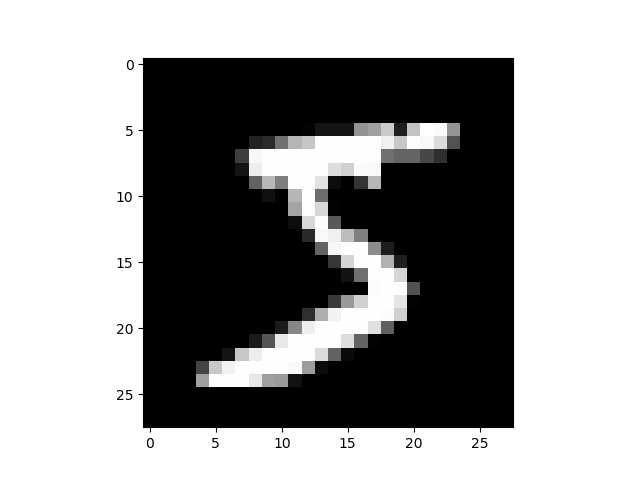

input images in train set
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
output classes in train set
[5 0 4 1 9 2 1 3 1 4]


In [5]:
# Load MNIST

# Load the dataset
with gzip.open('datasets/MNIST/mnist.pkl.gz', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    p = u.load()
train_set, valid_set, test_set = p
f.close()

def MNIST_row_as_image(row):
    arr1 = []
    for i in range(28):
        arr2 = []
        for j in range(28):
            arr2.append(row[28*i + j])
        arr1.append(arr2)
    return numpy.array(arr1)

plt.figure()
plt.imshow(MNIST_row_as_image(train_set[0][0]), cmap = cm.Greys_r)
plt.show()

print("input images in train set")
print(train_set[0][:10])
print("output classes in train set")
print(train_set[1][:10])

In [6]:
def FourLayerMNISTExample(cycles, output_weight_factor, hidden1_weight_factor, hidden2_weight_factor, random_output_weight_factor, random_21_weight_factor):

    # MNIST EXAMPLE 4-layer

    print("Running MNIST 4-layer example...")

    # Backprop
    net1 = four_layer_NN(28*28,200,100,10)
    net2 = four_layer_NN(28*28,200,100,10)

    net1.randomly_initialize_output_weight_matrix()
    net1.randomly_initialize_hidden_weight_matrices()
    
    # rescale weight matrices
    net1.weights_output = np.multiply(output_weight_factor , net1.weights_output)
    net1.weights_hidden1 = np.multiply(hidden1_weight_factor , net1.weights_hidden1)
    net1.weights_hidden2 = np.multiply(hidden2_weight_factor , net1.weights_hidden2)
    net1.random_weights_output = np.multiply(random_output_weight_factor , net1.random_weights_output)
    net1.random_weights_21 = np.multiply(random_21_weight_factor , net1.random_weights_21)


    net2.weights_output = net1.weights_output # initialize them all exactly the same
    net2.weights_hidden1 = net1.weights_hidden1 # initialize them all exactly the same
    net2.weights_hidden2 = net1.weights_hidden2 # initialize them all exactly the same

    agreementvect_BP = []
    agreementvect_FA = []

    angle_curve1 = []
    angle_curve2 = []

    distance_into_trainset = len(train_set[0])

    hidden_activation_list1_BP = []
    hidden_activation_list2_BP = []

    hidden_activation_list1_FA = []
    hidden_activation_list2_FA = []

    num_times_through_trainset = cycles

    for p in range(num_times_through_trainset): # keep going through the training set again and again
        print("%i th time through training set" % p)
        for j in range(len(train_set[0][:distance_into_trainset])):
            invector = train_set[0][j]
            target = np.zeros(10)
            target[train_set[1][j]] = 1

            old_hidden_BP_1 = net1.hidden_layer1.unit_netinputcurrents
            old_hidden_BP_2 = net1.hidden_layer2.unit_netinputcurrents
            net1.backprop_step(invector, target)
            net1.compute_network_output(invector)
            new_hidden_BP_1 = net1.hidden_layer1.unit_netinputcurrents
            new_hidden_BP_2 = net1.hidden_layer2.unit_netinputcurrents
            difference_hidden_BP_1 = new_hidden_BP_1-old_hidden_BP_1
            difference_hidden_BP_2 = new_hidden_BP_2-old_hidden_BP_2
            out_updatedBP = net1.output_layer.unit_outputs
            agreementvect_BP.append(target[np.argmax(out_updatedBP)])

            if j>distance_into_trainset-1000 and p == num_times_through_trainset-1: # grab vectors for tSNE
                hidden_activation_list1_BP.append(net1.hidden_layer1.unit_outputs)
                hidden_activation_list2_BP.append(net1.hidden_layer2.unit_outputs)

            old_hidden_FA_1 = net2.hidden_layer1.unit_netinputcurrents
            old_hidden_FA_2 = net2.hidden_layer2.unit_netinputcurrents
            net2.feedback_alignment_step(invector, target)
            net2.compute_network_output(invector)
            new_hidden_FA_1 = net2.hidden_layer1.unit_netinputcurrents
            new_hidden_FA_2 = net2.hidden_layer2.unit_netinputcurrents
            difference_hidden_FA_1 = new_hidden_FA_1-old_hidden_FA_1
            difference_hidden_FA_2 = new_hidden_FA_2-old_hidden_FA_2
            out_updatedFA = net2.output_layer.unit_outputs
            agreementvect_FA.append(target[np.argmax(out_updatedFA)])

            if j>distance_into_trainset-1000 and p == num_times_through_trainset-1: # grab vectors for tSNE
                hidden_activation_list1_FA.append(net2.hidden_layer1.unit_outputs)
                hidden_activation_list2_FA.append(net2.hidden_layer2.unit_outputs)

            angle1 = angle_func(difference_hidden_BP_1, difference_hidden_FA_1)
            angle_curve1.append(angle1)

            angle2 = angle_func(difference_hidden_BP_2, difference_hidden_FA_2)
            angle_curve2.append(angle2)
            
    windowsize = 200
    accuracyvect_BP = np.convolve(agreementvect_BP, np.ones((windowsize,))/windowsize, mode='valid')
    accuracyvect_FA = np.convolve(agreementvect_FA, np.ones((windowsize,))/windowsize, mode='valid')

    plt.figure()

    plt.plot(accuracyvect_BP, color = 'r', label = "backprop")
    plt.plot(accuracyvect_FA, color = 'g', label = "feedback alignment")

    plt.legend()

    plt.show()
    
    smoothed_angle_curve1 = np.convolve(angle_curve1, np.ones((100,))/100, mode='valid')
    plt.figure()
    plt.title("Angle between BP and FA hidden unit updates in hidden layer 1")
    plt.plot(smoothed_angle_curve1)
    plt.show()

    smoothed_angle_curve2 = np.convolve(angle_curve2, np.ones((100,))/100, mode='valid')
    plt.figure()
    plt.title("Angle between BP and FA hidden unit updates in hidden layer 2")
    plt.plot(smoothed_angle_curve2)
    plt.show()
    
    # Receptive fields of hidden layer
    field = np.reshape(net1.weights_hidden1[:][37], (28,28))
    plt.figure()
    plt.title("backprop: learned hidden feature")
    plt.imshow(field, cmap = cm.Greys_r)

    field = np.reshape(net2.weights_hidden1[:][37], (28,28))
    plt.figure()
    plt.title("feedback alignment: learned hidden feature")
    plt.imshow(field, cmap = cm.Greys_r)

    plt.show()
    
    # tSNE
    X_embedded = TSNE(n_components=2).fit_transform(hidden_activation_list1_BP)

    x = X_embedded[:,0]
    y = X_embedded[:,1]

    plt.figure()
    plt.title("learned hidden representations in hidden layer 1: backprop")
    plt.scatter(x,y, c = train_set[1][distance_into_trainset-1000+1:distance_into_trainset], cmap=plt.get_cmap("Spectral"))
    plt.show()

    X_embedded = TSNE(n_components=2).fit_transform(hidden_activation_list2_BP)

    x = X_embedded[:,0]
    y = X_embedded[:,1]

    plt.figure()
    plt.title("learned hidden representations in hidden layer 2: backprop")
    plt.scatter(x,y, c = train_set[1][distance_into_trainset-1000+1:distance_into_trainset], cmap=plt.get_cmap("Spectral"))
    plt.show()


    X_embedded = TSNE(n_components=2).fit_transform(hidden_activation_list1_FA)

    x = X_embedded[:,0]
    y = X_embedded[:,1]

    plt.figure()
    plt.title("learned hidden representations in hidden layer 1: feedback alignment")
    plt.scatter(x,y, c = train_set[1][distance_into_trainset-1000+1:distance_into_trainset], cmap=plt.get_cmap("Spectral"))
    plt.show()

    X_embedded = TSNE(n_components=2).fit_transform(hidden_activation_list2_FA)

    x = X_embedded[:,0]
    y = X_embedded[:,1]

    plt.figure()
    plt.title("learned hidden representations in hidden layer 2: feedback alignment")
    plt.scatter(x,y, c = train_set[1][distance_into_trainset-1000+1:distance_into_trainset], cmap=plt.get_cmap("Spectral"))

    plt.show()

Running MNIST 4-layer example...
0 th time through training set
1 th time through training set
2 th time through training set


<IPython.core.display.Javascript object>


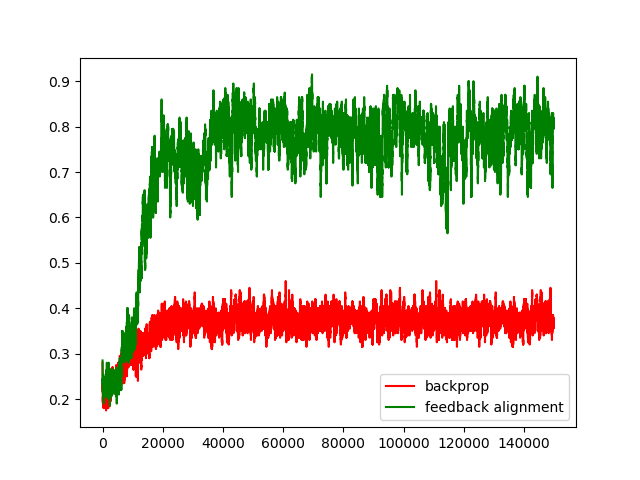

<IPython.core.display.Javascript object>


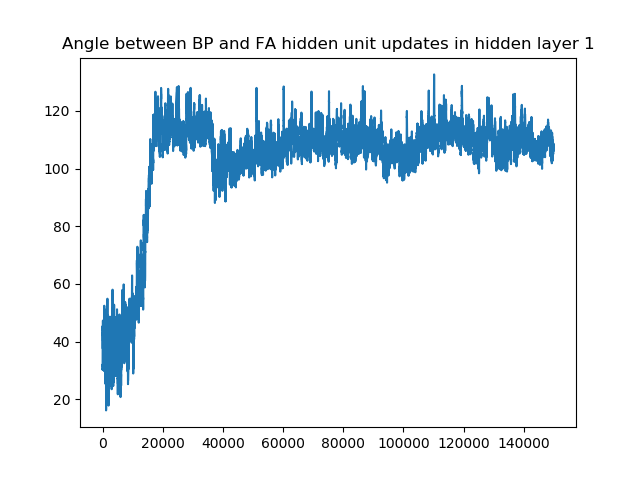

<IPython.core.display.Javascript object>


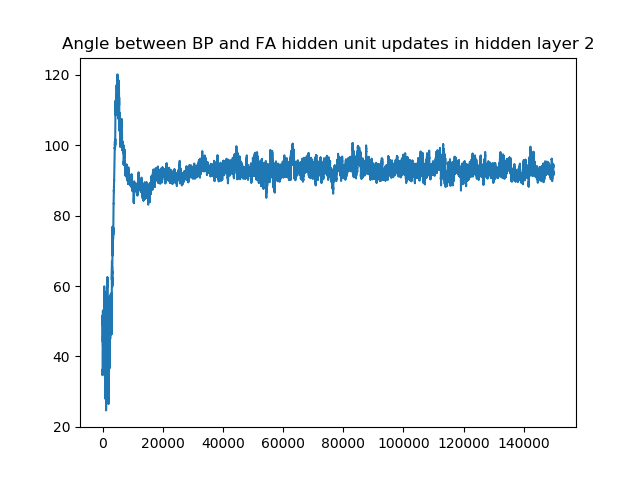

<IPython.core.display.Javascript object>


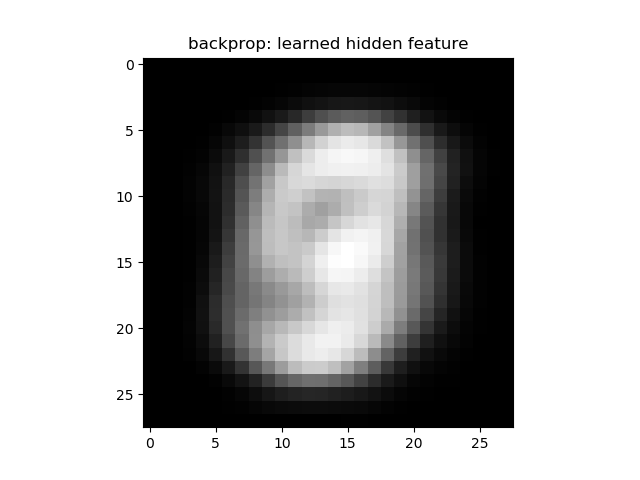

<IPython.core.display.Javascript object>


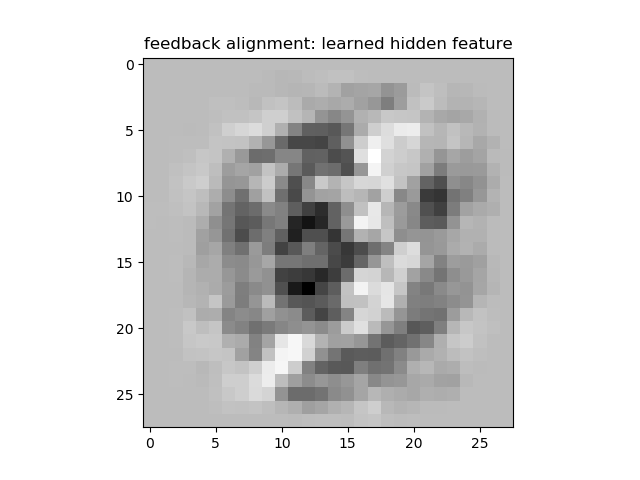

<IPython.core.display.Javascript object>


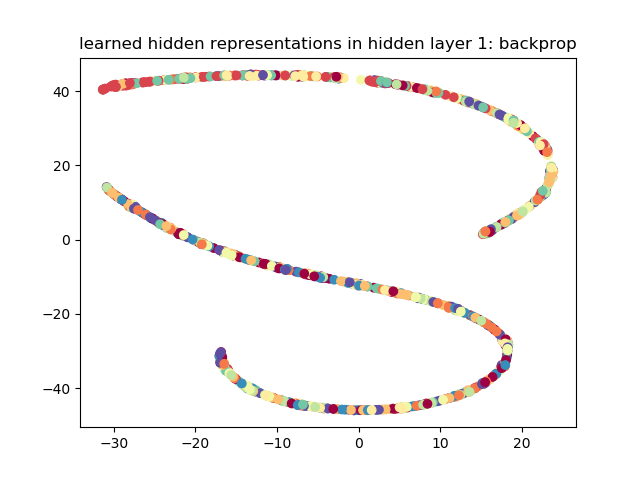

<IPython.core.display.Javascript object>


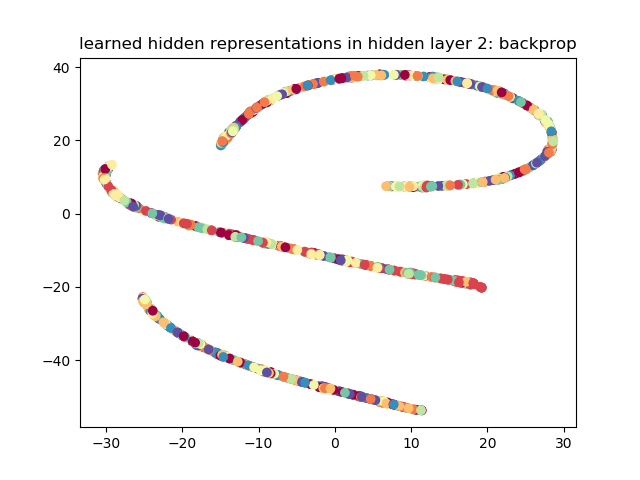

<IPython.core.display.Javascript object>


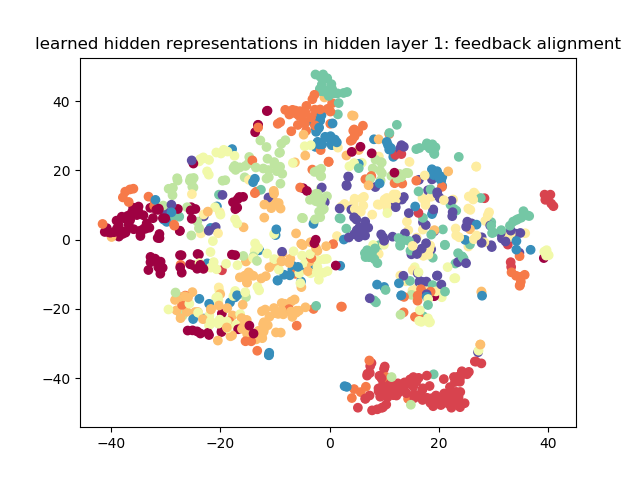

<IPython.core.display.Javascript object>


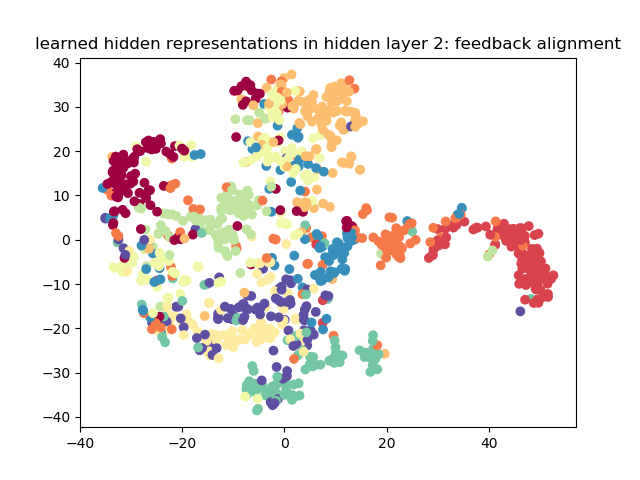

In [7]:
FourLayerMNISTExample(cycles = 3, output_weight_factor = 0.01, hidden1_weight_factor = 0.01, hidden2_weight_factor = 0.01, random_output_weight_factor = 0.3 , random_21_weight_factor = 0.3)

# This breaks backprop but kinda allows feedback alignment to work, with self.weight_decay = 0.0001 

Running MNIST 4-layer example...
0 th time through training set
1 th time through training set
2 th time through training set
3 th time through training set
4 th time through training set


<IPython.core.display.Javascript object>


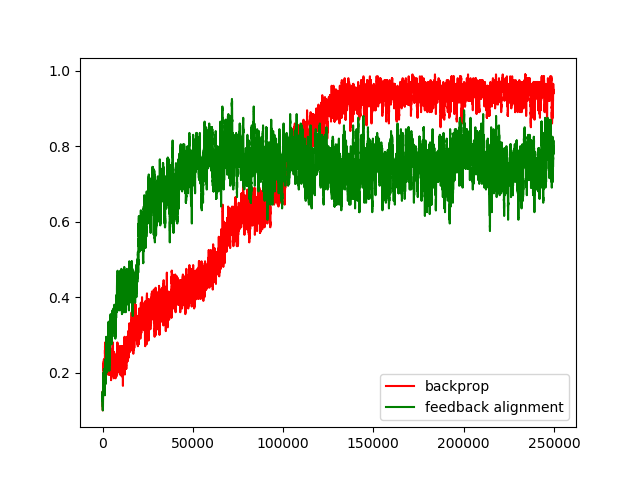

<IPython.core.display.Javascript object>


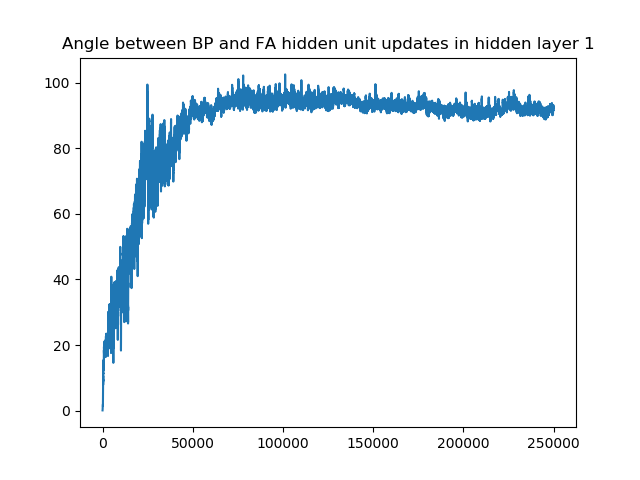

<IPython.core.display.Javascript object>


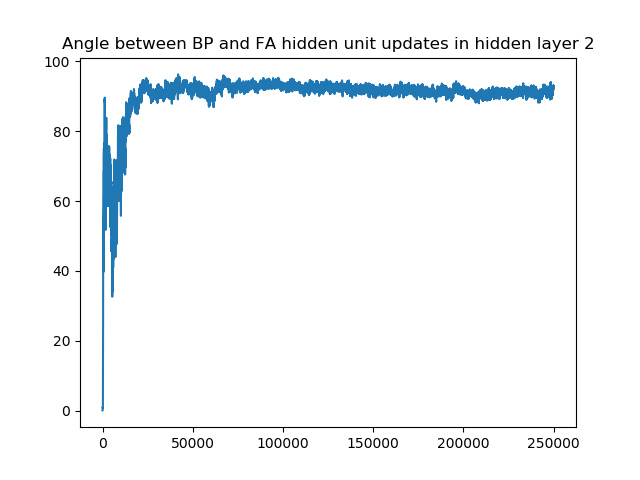

<IPython.core.display.Javascript object>


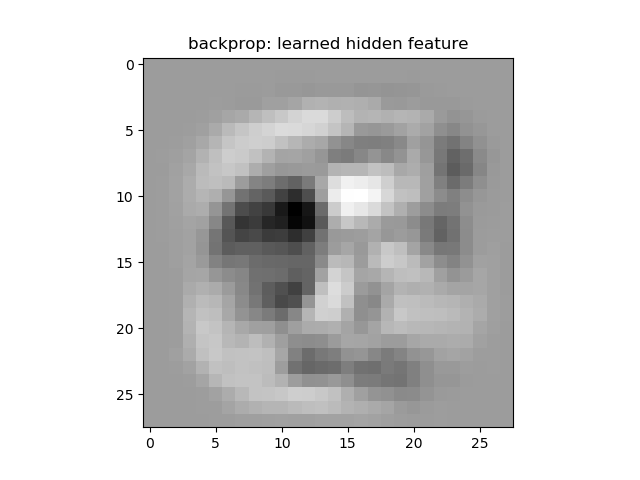

<IPython.core.display.Javascript object>


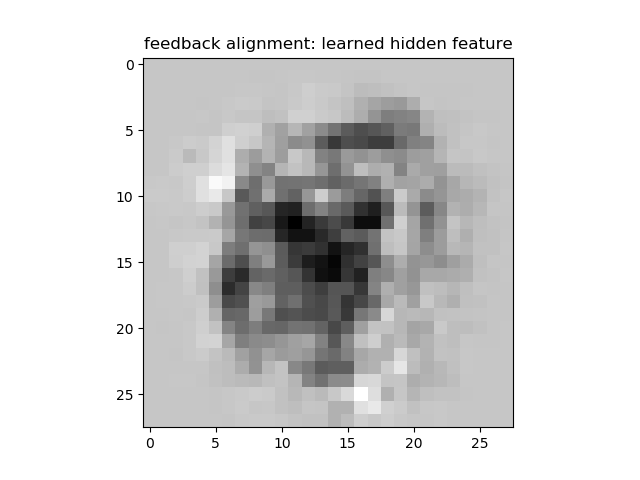

<IPython.core.display.Javascript object>


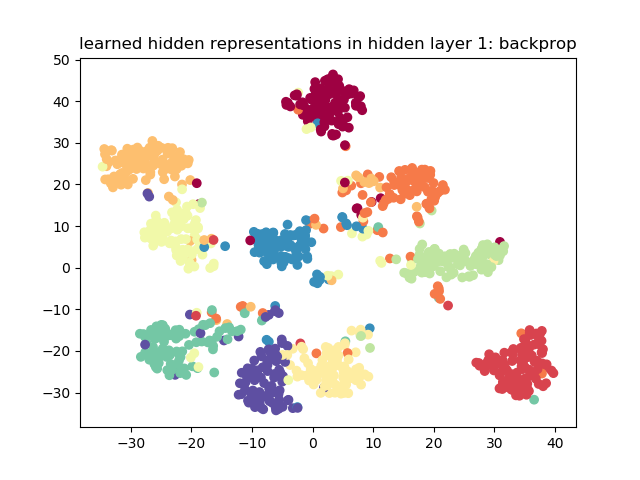

<IPython.core.display.Javascript object>


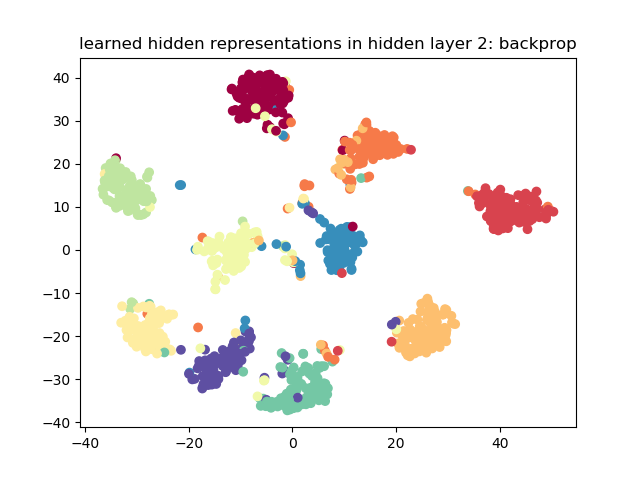

<IPython.core.display.Javascript object>


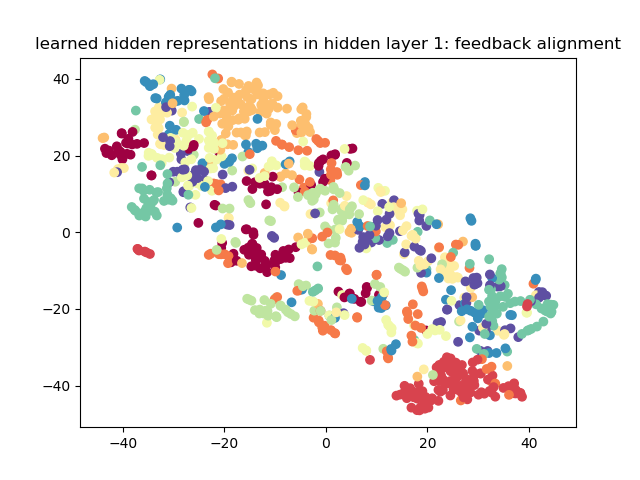

<IPython.core.display.Javascript object>


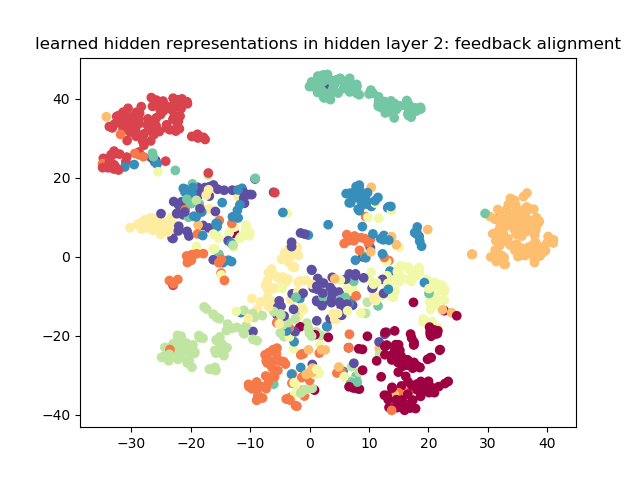

In [9]:
FourLayerMNISTExample(cycles = 5, output_weight_factor = 0.1, hidden1_weight_factor = 0.1, hidden2_weight_factor = 0.1, random_output_weight_factor = 0.3 , random_21_weight_factor = 0.3)

# Rescues backprop, feedback alignment does kind of OK, with self.weight_decay = 0.0001 

Running MNIST 4-layer example...
0 th time through training set
1 th time through training set
2 th time through training set
3 th time through training set
4 th time through training set
5 th time through training set
6 th time through training set
7 th time through training set
8 th time through training set
9 th time through training set


<IPython.core.display.Javascript object>


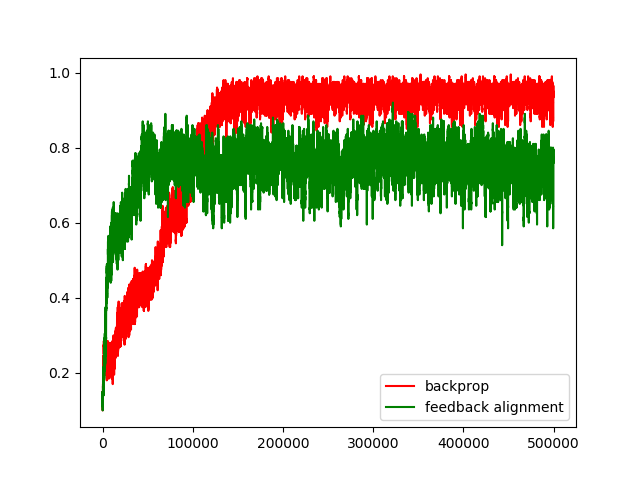

/Users/adammarblestone/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


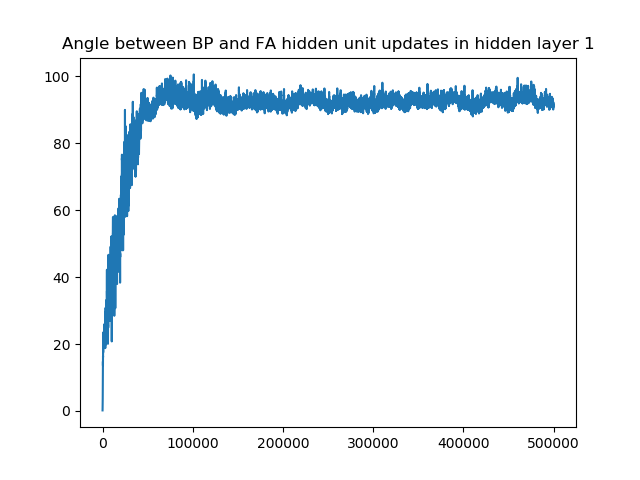

<IPython.core.display.Javascript object>


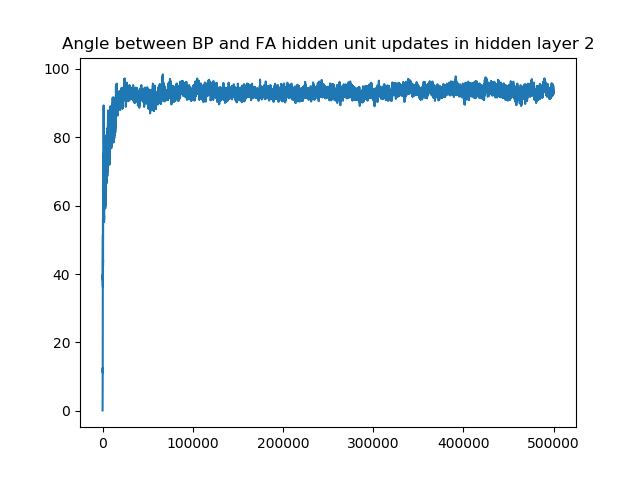

<IPython.core.display.Javascript object>


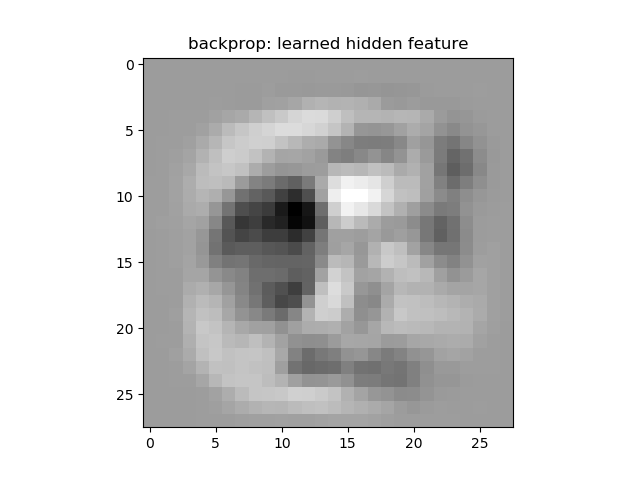

<IPython.core.display.Javascript object>


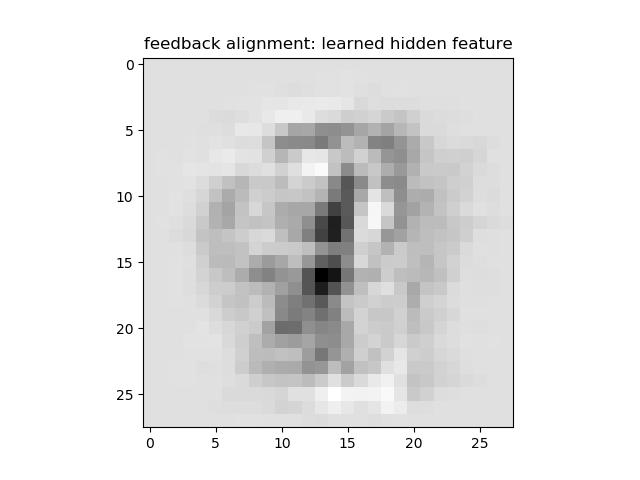

<IPython.core.display.Javascript object>


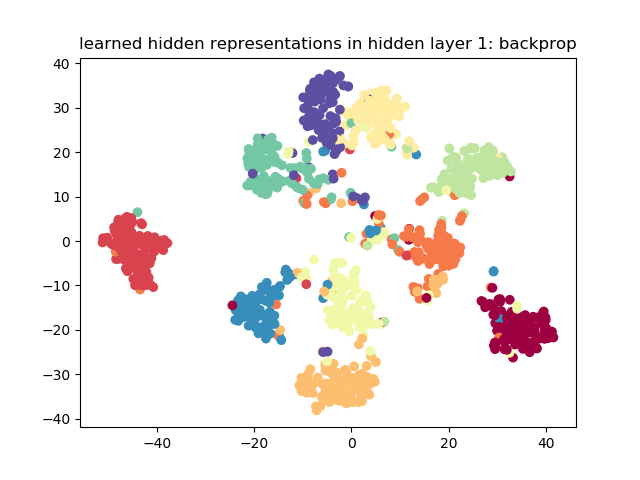

<IPython.core.display.Javascript object>


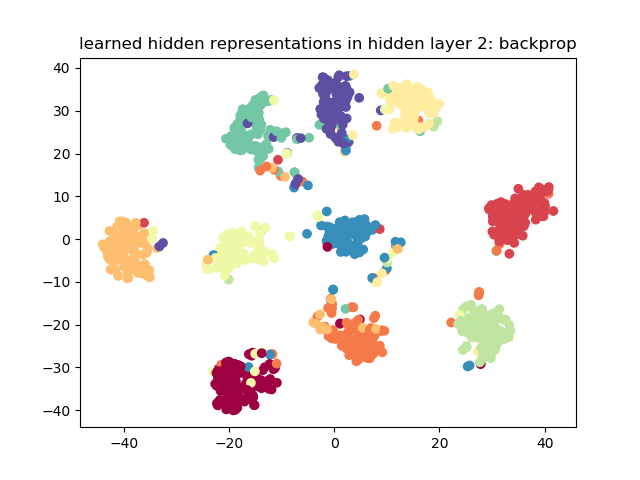

<IPython.core.display.Javascript object>


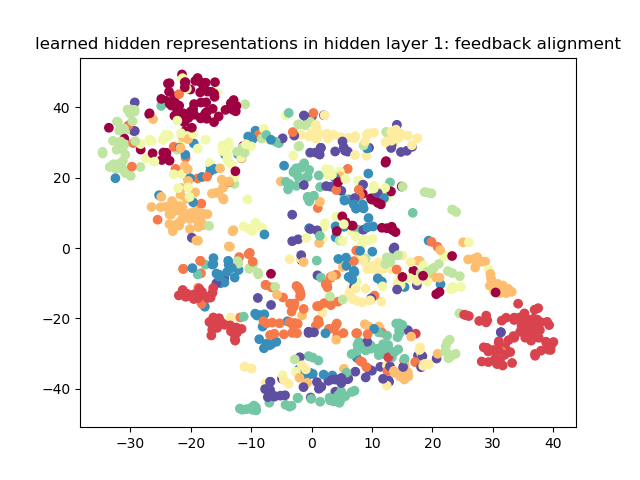

<IPython.core.display.Javascript object>


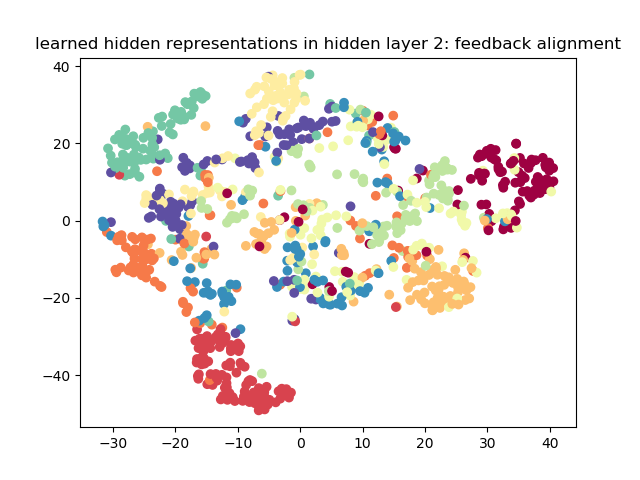

In [10]:
FourLayerMNISTExample(cycles = 10, output_weight_factor = 0.1, hidden1_weight_factor = 0.1, hidden2_weight_factor = 0.1, random_output_weight_factor = 0.3 , random_21_weight_factor = 0.3)

# Same parameters as the last one but running for more cycles to see if feedback alignment ultimately reaches high accuracy

Running MNIST 4-layer example...
0 th time through training set
1 th time through training set
2 th time through training set
3 th time through training set
4 th time through training set
5 th time through training set
6 th time through training set
7 th time through training set
8 th time through training set
9 th time through training set


/Users/adammarblestone/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


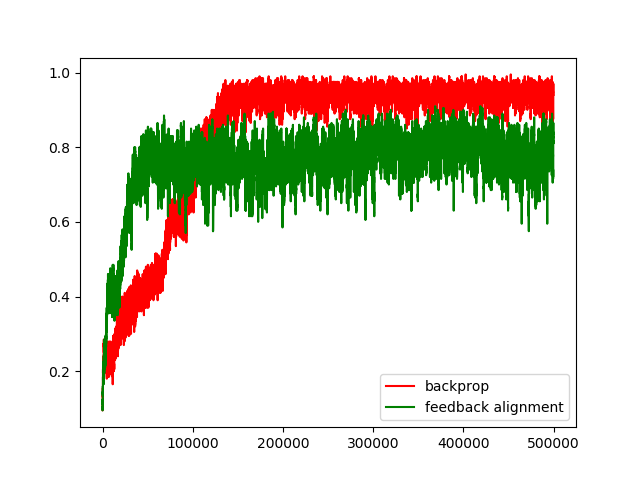

<IPython.core.display.Javascript object>


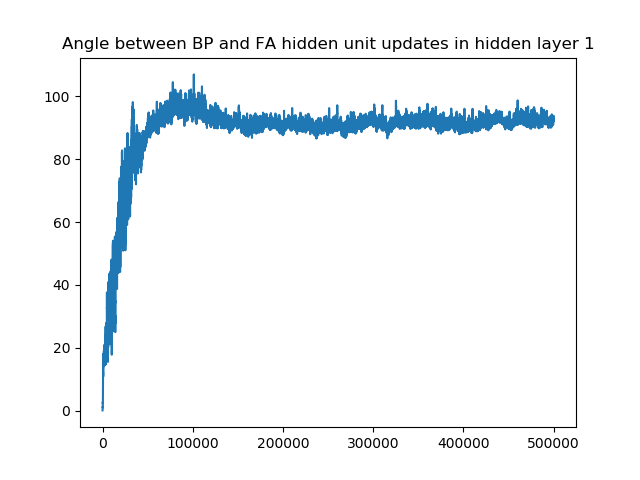

<IPython.core.display.Javascript object>


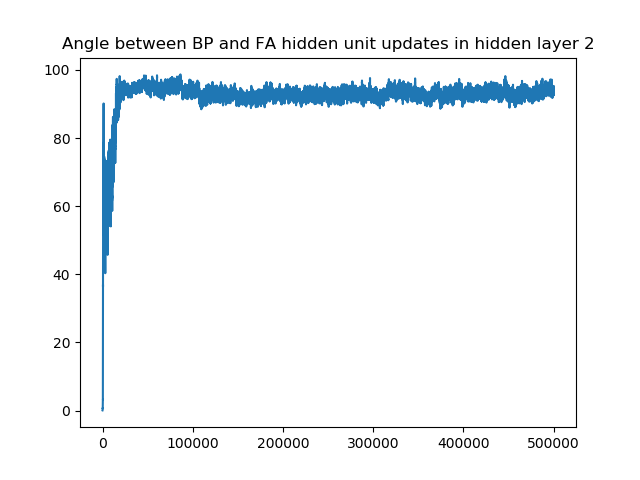

<IPython.core.display.Javascript object>


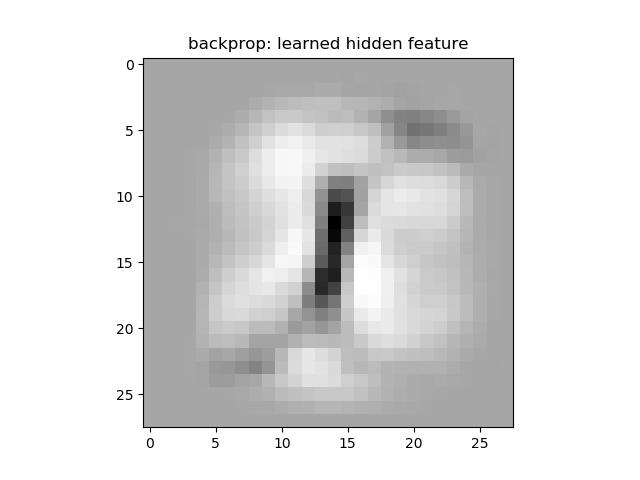

<IPython.core.display.Javascript object>


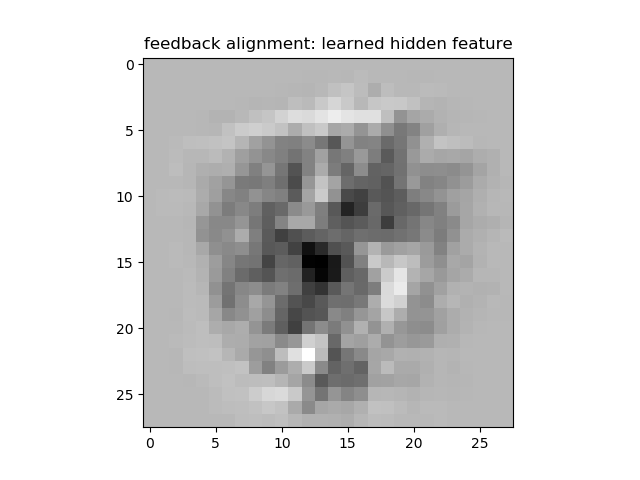

<IPython.core.display.Javascript object>


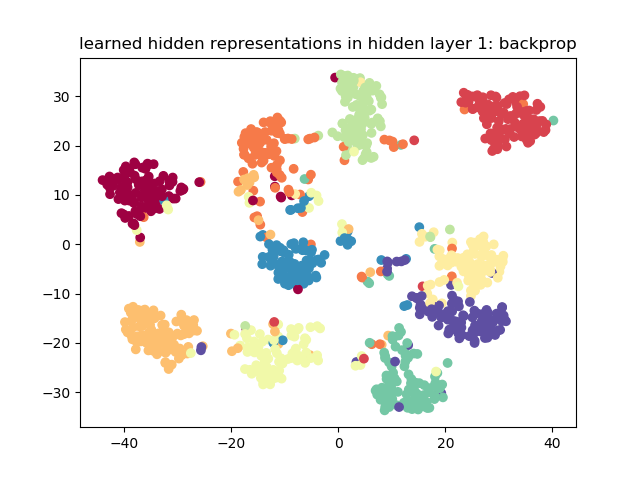

<IPython.core.display.Javascript object>


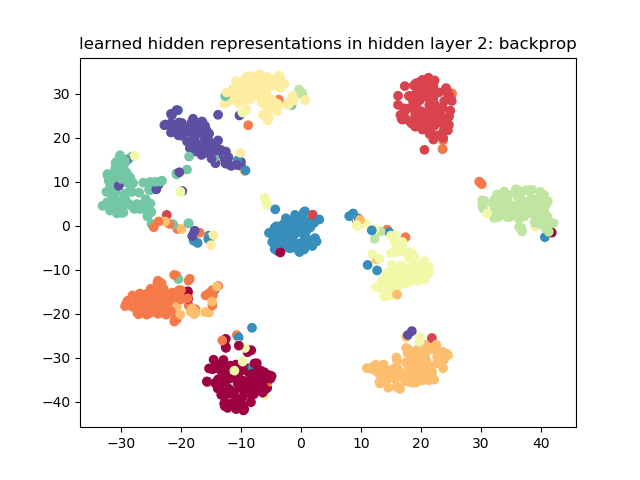

<IPython.core.display.Javascript object>


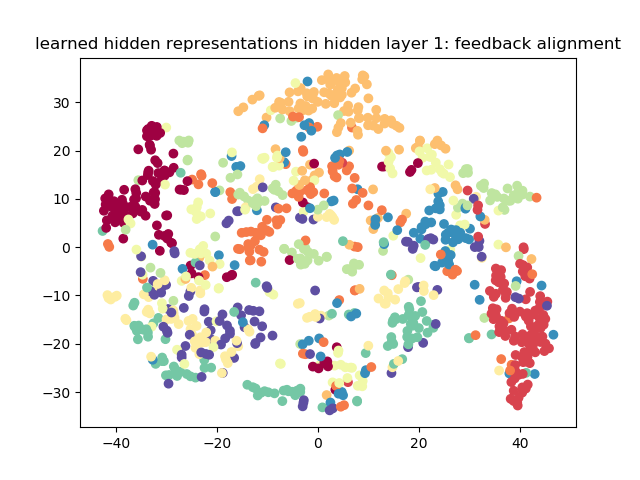

<IPython.core.display.Javascript object>


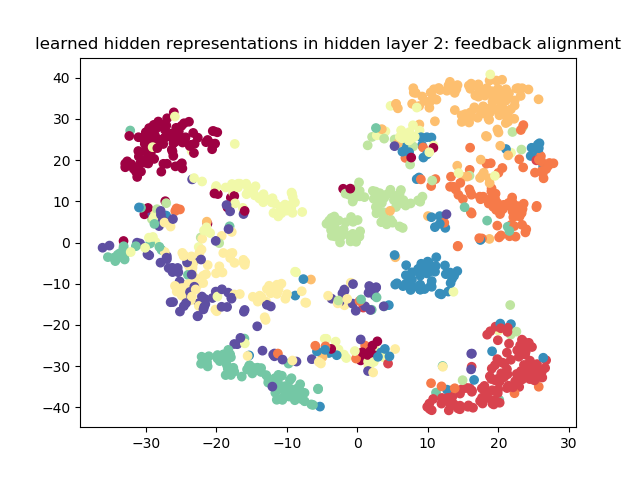

In [11]:
FourLayerMNISTExample(cycles = 10, output_weight_factor = 0.1, hidden1_weight_factor = 0.1, hidden2_weight_factor = 0.1, random_output_weight_factor = 0.03 , random_21_weight_factor = 0.03)

# Another small variation